# Exporting American Movie Box Office Hits 

### Regresssion Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [Scraped: Movie Adaptations Data](#2) <br/>
3. [Exporatory Data Analysis: Movie Adaptations Dataframe](#3)<br/>
   [3a. Explore features correlation](#3a)<br/>
   [3b. Explore and handle categorical data](#3b)<br/>
4. [Cross-Validation](#4)<br/>
5. [Modeling](#5)<br/>
6. [Model Tuning](#6) <br/>
   [6a. Regularization](#6a)<br/>
   [6b. Features engineering](#6b)<br/>
   [6c. Linear regression assumptions](#6c)<br/>
7. [Best Model ](#7)<br/>
8. [Results](#8)<br/>
   [8a. Interpretability](#8a)<br/>
   [8b. Predictions](#8b)<br/>

In [47]:
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline


## 1. Research Question<a id='1'></a> 

* RQ. Can a model predict a movie adaptaion <sup>1</sup> international total gross revenue based on movie data available on boxofficemojo.com?
* Data source: boxofficemojo.com 
* Error metric: mean_squared_error

<sup>1</sup> Adapted from books, television shows, events, video games, or plays. 


## 2. Scraped [Movie Adaptations Data](https://github.com/slp22/regression-project/blob/main/adaptation_movies_webscraping.ipynb) 


## 3. Exporatory Data Analysis: [Movie Adaptations Dataframe](https://github.com/slp22/regression-project/blob/main/adaptation_movies_eda.ipynb) 

In [30]:
movie_df = pd.read_csv('clean_df.csv')
movie_df.drop(columns=['link_stub'], inplace=True)
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,PG


In [ ]:
movie_df.describe()

In [ ]:
# check for null values
movie_df.isnull().sum()

In [31]:
# interpolate null values
movie_df['opening_theathers'] = movie_df['opening_theathers'].interpolate()
movie_df['runtime'] = movie_df['runtime'].interpolate()
movie_df['max_theaters'] = movie_df['max_theaters'].interpolate()

In [32]:
# double check for null values
movie_df.isnull().sum()

international_total_gross      0
domestic_total_gross           0
rank                           0
movie_title                    0
max_theaters                   0
opening_theathers              0
worldwide_total_gross          0
domestic_opening               0
budget                         0
release_date                   0
runtime                        0
distributor                    2
genres                         0
rating                       167
dtype: int64

### 3a. Explore features correlation<a id='3a'></a> 

In [ ]:
# sns.pairplot(movie_df, height=5, aspect=1.5);

In [ ]:
# heatmap correlation matrix
sns.heatmap(movie_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

### Correlation Summary

#### Target-Features
*target = `international_total_gross`*
* target correlated with (highest to lowest):
    * `domestic_total_gross`
    * `domestic_opening`
    * `budget`
    * `max_theaters`
    * `opening_theathers`

Target is highly correlated with `worldwide_total_gross`; has known multicollinearity as:<br/>
`worldwide_total_gross` = `domestic_total_gross` + `international_total_gross`

####  Features-Features: Positive Correlation
* domestic_total_gross:
    * `domestic_opening`
    * `worldwide_total_gross`
    * `budget`
    * `max_theaters`
    * `opening_theathers`
* domestic_opening:<br/>
    * `budget`
    * `max_theaters`
    * `opening_theathers`
* max_theaters:
    * `opening_theathers`
    * `budget`
    * `domestic_opening`

####  Features-Features: Negative Correlation
* rank:
    * `domestic_total_gross`
    * `max_theaters`
    * `opening_theathers`
    * `domestic_opening`
    * `budget`
    


### 3b. Explore and handle categorical data<a id='3b'></a> 

In [ ]:
# explore genres as candidate for dummies
print('Unique genres:', movie_df.genres.nunique())
print('\n')
print('Genres counts\n', movie_df['genres'].value_counts())

# 👎 Too many for easy-to-use dummy value; let's see what other data works for dummy variables. 

In [33]:
# explore MPAA rating as candidate for dummies
print('Unique MPAA ratings:', movie_df.rating.nunique())
print('\n')
rating_count = movie_df['rating'].value_counts()
print('Rating counts\n', rating_count)
# 👍 Easy-to-use for dummy variables


Unique MPAA ratings: 5


Rating counts
 PG13    308
R       223
PG      194
G         8
NC17      1
Name: rating, dtype: int64


In [34]:
# get dummies for MPAA rating 
df_dummies_rating = pd.get_dummies(movie_df, columns=['rating'], drop_first=True)
df_dummies_rating.head(2)
movie_df = df_dummies_rating
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,runtime,distributor,genres,rating_NC17,rating_PG,rating_PG13,rating_R
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,118.0,Walt Disney Studios Motion Pictures,Adventure Animation Drama Family Musical,0,1,0,0


In [35]:
# explore distributor as candidate for dummies 
print('Unique distributors:', movie_df.distributor.nunique())
print('\n')
distributor_count = movie_df['distributor'].value_counts()
print('Distributor count\n', distributor_count)
# 👍 Reasonable amount, group lower frequencies into an other category.

Unique distributors: 92


Distributor count
 Warner Bros.                           143
Walt Disney Studios Motion Pictures    102
Twentieth Century Fox                  101
Paramount Pictures                     101
Universal Pictures                      94
                                      ... 
Cineplex Odeon Films                     1
FIP                                      1
Amazon Studios                           1
Romar Entertainment                      1
Distrib Films                            1
Name: distributor, Length: 92, dtype: int64


In [36]:
# create distributor other category
distributor_other = list(distributor_count[distributor_count < 20].index)
movie_df['distributor'] = movie_df['distributor'].replace(distributor_other, 'other')

# get dummies for distributor
df_dummies_distributor = pd.get_dummies(movie_df, columns=['distributor'], drop_first=True)
movie_df = df_dummies_distributor
movie_df.head(1)

,international_total_gross,domestic_total_gross,rank,movie_title,max_theaters,opening_theathers,worldwide_total_gross,domestic_opening,budget,release_date,...,rating_PG13,rating_R,distributor_New Line Cinema,distributor_Paramount Pictures,distributor_Sony Pictures Entertainment (SPE),distributor_Twentieth Century Fox,distributor_Universal Pictures,distributor_Walt Disney Studios Motion Pictures,distributor_Warner Bros.,distributor_other
0,1119261396,543638043,6,The Lion King,4802.0,4725.0,1662899439,191770759,260000000,20190711,...,0,0,0,0,0,0,0,1,0,0


In [37]:
movie_df.columns

Index(['international_total_gross', 'domestic_total_gross', 'rank',
       'movie_title', 'max_theaters', 'opening_theathers',
       'worldwide_total_gross', 'domestic_opening', 'budget', 'release_date',
       'runtime', 'genres', 'rating_NC17', 'rating_PG', 'rating_PG13',
       'rating_R', 'distributor_New Line Cinema',
       'distributor_Paramount Pictures',
       'distributor_Sony Pictures Entertainment (SPE)',
       'distributor_Twentieth Century Fox', 'distributor_Universal Pictures',
       'distributor_Walt Disney Studios Motion Pictures',
       'distributor_Warner Bros.', 'distributor_other'],
      dtype='object')

[back to top](#top)

## 4. Cross-Validation<a id='4'></a> 

In [38]:
# separate target from select features
y = movie_df['international_total_gross']
X = movie_df.loc[:,['domestic_total_gross', 
                    'domestic_opening', 
                    'budget',
                    'rank',
                    'max_theaters', 
                    'opening_theathers',
                    'runtime',
#                     'movie_title', 
                    'rating_NC17', 
                    'rating_PG', 
                    'rating_PG13',
                    'rating_R',
                    'distributor_New Line Cinema',
                    'distributor_Paramount Pictures',
                    'distributor_Sony Pictures Entertainment (SPE)',
                    'distributor_Twentieth Century Fox', 
                    'distributor_Universal Pictures',
                    'distributor_Walt Disney Studios Motion Pictures',
                    'distributor_Warner Bros.', 
                    'distributor_other']]

In [39]:
# split test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
## set up k-folds 
kfold = KFold(n_splits=5, shuffle=True, random_state = 42)

[back to top](#top)

## 5. Modeling<a id='5'></a> 

In [53]:
# simple linear regression
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train, y_train, cv=kfold)
print('k-fold indivdual scores:', scores)
print("linear regression mean score: ", np.mean(scores))

lin_reg.fit(X_train, y_train)

k-fold indivdual scores: [0.78049637 0.72548184 0.72475197 0.87136752 0.7393592 ]
linear regression mean score:  0.7682913800987009


LinearRegression()

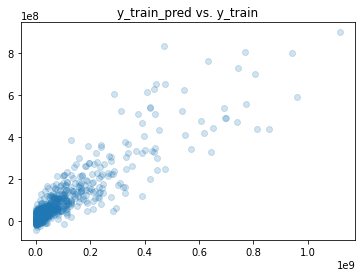

In [57]:
# train: fitted vs. actual
y_train_pred = lin_reg.predict(X_train)

plt.scatter(y_train, y_train_pred, alpha=0.2)
plt.plot([0, 400], [0, 400])
plt.title("y_train_pred vs. y_train");

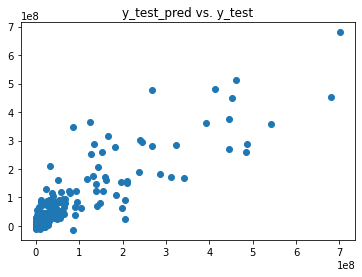

In [58]:
# test: fitted vs. actual
y_test_pred = lin_reg.predict(X_test)

plt.scatter(y_test, y_test_pred)
plt.plot([0, 400], [0, 400])
plt.title("y_test_pred vs. y_test");

Text(0.5, 1.0, 'Residuals vs. Predictions')

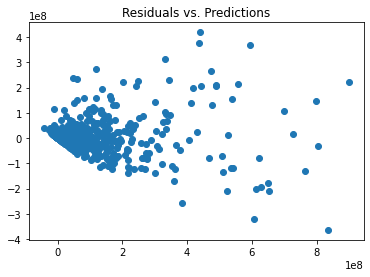

In [56]:
# residuals vs. predicted
lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lin_reg_residuals)
plt.plot([0,400], [0, 0])
plt.title("Residuals vs. Predictions")

## 6. Model Tuning<a id='6'></a> 

In [60]:
# standard-scaling features before regularization 
std = StandardScaler()
std.fit(X_train.values)

## apply scaler to train data
X_train = std.transform(X_train.values)

## apply scaler to test data
X_test = std.transform(X_test.values)

### 6a. Regularization<a id='6a'></a> 

[regression_lasso_solution](http://localhost:8888/notebooks/Documents/GitHub/metis_dsml/02_regression/02_regression_exercises/08-regularization/regression_lasso_solution.ipynb)


Lasso Model
Lasso(alpha=0.01)
[1.00000000e-02 1.04737090e-02 1.09698580e-02 1.14895100e-02
 1.20337784e-02 1.26038293e-02 1.32008840e-02 1.38262217e-02
 1.44811823e-02 1.51671689e-02 1.58856513e-02 1.66381689e-02
 1.74263339e-02 1.82518349e-02 1.91164408e-02 2.00220037e-02
 2.09704640e-02 2.19638537e-02 2.30043012e-02 2.40940356e-02
 2.52353917e-02 2.64308149e-02 2.76828663e-02 2.89942285e-02
 3.03677112e-02 3.18062569e-02 3.33129479e-02 3.48910121e-02
 3.65438307e-02 3.82749448e-02 4.00880633e-02 4.19870708e-02
 4.39760361e-02 4.60592204e-02 4.82410870e-02 5.05263107e-02
 5.29197874e-02 5.54266452e-02 5.80522552e-02 6.08022426e-02
 6.36824994e-02 6.66991966e-02 6.98587975e-02 7.31680714e-02
 7.66341087e-02 8.02643352e-02 8.40665289e-02 8.80488358e-02
 9.22197882e-02 9.65883224e-02 1.01163798e-01 1.05956018e-01
 1.10975250e-01 1.16232247e-01 1.21738273e-01 1.27505124e-01
 1.33545156e-01 1.39871310e-01 1.46497140e-01 1.53436841e-01
 1.60705282e-01 1.68318035e-01 1.76291412e-01 1.8464249

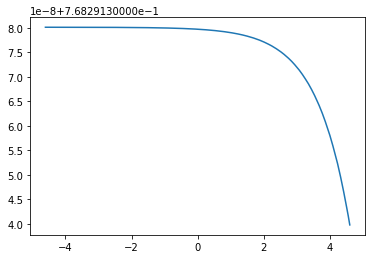

In [74]:
print("Lasso Model")
params = {'alpha': 10**np.linspace(-2,2,200)}

grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kfold, return_train_score=False)
grid_est.fit(X_train, y_train)

df = pd.DataFrame(grid_est.cv_results_)

df["alpha"] = df.params.apply(lambda val: val["alpha"])

plt.plot(np.log(df.alpha), df.mean_test_score);
print(grid_est.best_estimator_)
print(params['alpha'])

In [66]:
y_pred = lin_reg.predict(X_test)
print("Linear Regression:", mean_squared_error(y_test, y_pred))

y_pred = lasso_grid_est.predict(X_test)
print("Lasso Regression:", mean_squared_error(y_test, y_pred))

y_pred = ridge_grid_est.predict(X_test)
print("Ridge Regression:", mean_squared_error(y_test, y_pred))

y_pred = elastic_net_grid_est.predict(X_test)
print("ElasticNet Regression:", mean_squared_error(y_test, y_pred))

Linear Regression: 8.682595258363733e+16
Lasso Regression: 4440317966060504.5
Ridge Regression: 4441382191433629.0
ElasticNet Regression: 4587579236911731.0


/Users/sandraparedes/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


[back to top](#top)

### 6b. Features engineering<a id='6b'></a> 

In [ ]:
# log transformation for monetary columns 

# check for zeros in columns before log transformation 
count = (movie_df['international_total_gross'] == 0).sum()
print('count of international_total_gross in budget:', count)

count = (movie_df['domestic_total_gross'] == 0).sum()
print('count of domestic_total_gross in budget:', count)

count = (movie_df['budget'] == 0).sum()
print('count of zeros in budget:', count)

count = (movie_df['domestic_opening'] == 0).sum()
print('count of zeros in domestic_opening:', count)

# 👍 international_total_gross and domestic_total_gross

# international_total_gross: min $98, max $1,119,261,000
movie_df['log_international_total_gross'] = np.log(movie_df['international_total_gross'])

# domestic_total_gross: min $742, max $543,638,043
movie_df['log_domestic_total_gross'] = np.log(movie_df['domestic_total_gross'])



# # 👎 zeros throw division-zero error; hold for now 
# # domestic_opening: min $0, max $191,770,800
# movie_df['log_domestic_opening'] = np.log(movie_df['domestic_opening'])

# # budget: min $0, max $270,000,000
# movie_df['log_budget'] = np.log(movie_df['budget'])



In [ ]:
# profit = domestic_total_gross - budget

movie_df['profit'] = (movie_df['domestic_total_gross'] - movie_df['budget'])

In [ ]:
# opening = domestic_opening * opening_theathers

movie_df['opening'] = (movie_df['domestic_opening'] * movie_df['opening_theathers'])

[back to top](#top)

### 6c. Linear regression assumptions<a id='6c'></a> 
    1. Remove multicollinearity
    2. Transform some features
    3. Look at QQ plots of residuals
    4. Check for independence of errors
    5. Check for heteroskedasticity in residuals!


In [ ]:
# Assumption 1: regression is linear in parameters and correctly specified

# Dx Regression fit: Inspect plot of observed data vs predicted values (points should be symmetric around the line).
# Dx Residual plot: Points should be symmetric around y=0 with roughly constant variance. 
##Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic errors whenever it is making unusually large or small predictions.
# Q-Q plot: Look for the middle section of dots to be very close to the diagonal red line. 
##Use the chart below as a reference for interpretation.


![](https://i.stack.imgur.com/ZXRkL.png)

In [ ]:
# Assumption 2: residuals ( ${e_i} = Y_i-\hat{Y}_i$ ) should be normally distributed with zero mean
# diagnose/inspect residual normality using qqplot:

stats.probplot(data['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [ ]:
# Assumption 3: error terms must have constant variance

# create residual plot
movie['predict']=fit.predict(X)
movie['resid']= y-movie.predict
with sns.axes_style('white'):
    plot = movie.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))
    
# create histogram
movie.DomesticTotalGross.hist();
# note the positive skew

# quick reg plot
plt.scatter(movie.Budget,y)
plt.scatter(movie.Budget,movie.predict);

In [ ]:
# Assumption 4: errors are uncorrelated across observations



In [ ]:
# Assumption 5: no independent variable is a perfect linear function of any other independent variable 
# (no perfect multi-collinearity)

Ways to diagnose: 
1. Inspect correlations of independent features
2. Keep an eye on condition number!
3. As noted above, `statsmodels` will notify you of [large condition numbers](https://en.wikipedia.org/wiki/Condition_number).

Ways to fix:<br/>
3. Consider Partial Least Squares or projection into latent space (PCA, introduced in the second-half of the course)<br/>
4. Use Ridge regularization<br/>

Incorporating [Ridge regularization](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) not only fixes this issue (if it exists, still safe to use if it doesn't), but it imparts other benefits as well. We'll use Ridge quite often after it's officially introduced!

[back to top](#top)

## 7. Best Model<a id='7'></a> 
Fit best model on (train + val), score on test!

In [ ]:
# pd.DataFrame(list(zip(range(10), lasso_grid_est.best_estimator_.coef_)))

[back to top](#top)

## 8. Results<a id='8'></a> 

### 8a. Interpretability<a id='8a'></a> 

In [ ]:
# Coefficients, what are the top predictors

### 8b. Predictions<a id='8b'></a> 

In [ ]:
# Make a prediction for a new value, does it make sense?

In [ ]:
# linear regression plot
f, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x='domestic_total_gross', y='international_total_gross', data=movie_df);


Slides, article, and code available at: https://github.com/slp22/regression-project

[back top top](#top)